In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import os
import gzip
import pickle
import math

def load_compressed(path):
    with gzip.open(path, 'rb') as f:
        return pickle.load(f)
dataset = load_compressed('/kaggle/input/hla-antigen-datapre/transphla_train_embedding.pkl.gz')
print(f'Loaded dataset size: {len(dataset)}')
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
del dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Loaded dataset size: 2154996


In [2]:
class HLA_Antigen_Cross(nn.Module):
    def __init__(self, input_dim_1=21, input_dim_2=21, seq_len_1=30, seq_len_2=30, d_model=64):
        super(HLA_Antigen_Cross, self).__init__()
        self.seq_len_1 = seq_len_1
        self.seq_len_2 = seq_len_2
        self.d_model = d_model
        self.linear_in_1 = nn.Linear(input_dim_1, d_model)
        self.linear_in_2 = nn.Linear(input_dim_2, d_model)
        self.cross_attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=4, batch_first=True, dropout=0.1)
        self.layer_norm = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(d_model * 4, d_model)
        )

    def forward(self, x1, x2):
        pos_1 = self.create_sinusoidal_embeddings(x1.size(0), self.seq_len_1, self.d_model).to(x1.device)
        pos_2 = self.create_sinusoidal_embeddings(x2.size(0), self.seq_len_2, self.d_model).to(x2.device)
        x1 = self.linear_in_1(x1) + pos_1
        x2 = self.linear_in_2(x2) + pos_2
        attn_output, _ = self.cross_attn(query=x1, key=x2, value=x2)
        x1_x2_attn_norm = self.layer_norm(attn_output + x1 + x2)
        ff_output = self.feed_forward(x1_x2_attn_norm)
        output = self.layer_norm(ff_output + x1_x2_attn_norm)
        return output

    @staticmethod
    def create_sinusoidal_embeddings(batch_size, n_position, d_model):
        """Creates a tensor of sinusoidal positional embeddings for a specific batch size."""
        position = torch.arange(0, n_position).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(batch_size, n_position, d_model)
        pe[:, :, 0::2] = torch.sin(position * div_term)
        pe[:, :, 1::2] = torch.cos(position * div_term)
        return pe

In [3]:
class pHLA_Model(nn.Module):
    def __init__(self):
        super(pHLA_Model, self).__init__()
        self.cross_attention_module = HLA_Antigen_Cross()
        self.fc2 = nn.Sequential(
            nn.Linear(64 + 21*30 + 21*30, 2048), 
            nn.Sigmoid(),
            nn.Dropout(0.1),
            nn.Linear(2048, 2048), 
            nn.Sigmoid(),
            nn.Dropout(0.1),
            nn.Linear(2048, 1024), 
            nn.Sigmoid(),
            nn.Dropout(0.1),
            nn.Linear(1024, 1),
        )

    def forward(self, peptides, hla_seqs):
        cross_attn_output = self.cross_attention_module(peptides, hla_seqs)
        flat_peptides = peptides.view(peptides.size(0), -1) 
        flat_hla_seqs = hla_seqs.view(hla_seqs.size(0), -1) 
        combined_features = torch.cat([cross_attn_output.mean(dim=1), flat_peptides, flat_hla_seqs], dim=1)
        logits = self.fc2(combined_features)
        return logits

In [4]:
def train(epoch, model, criterion, optimizer, train_loader, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for peptides, hla_seqs, labels in train_loader:
        peptides, hla_seqs, labels = peptides.to(device), hla_seqs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(peptides, hla_seqs)
        outputs = outputs.squeeze() 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = (outputs > 0).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    print(f'Train Epoch: {epoch} Loss: {train_loss:.4f} Accuracy: {train_acc:.2f}%')
    return train_loss, train_acc

def validate(model, criterion, val_loader, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for peptides, hla_seqs, labels in val_loader:
            peptides, hla_seqs, labels = peptides.to(device), hla_seqs.to(device), labels.to(device)
            outputs = model(peptides, hla_seqs)
            outputs = outputs.squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            predicted = (outputs > 0).float() 
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    print(f'Validation Loss: {val_loss:.4f} Accuracy: {val_acc:.2f}%')
    return val_loss, val_acc

In [5]:
model = pHLA_Model().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
epochs = 300
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
best_val_acc = 0
no_improve_epochs = 0
patience = 30

for epoch in range(1, epochs + 1):
    train_loss, train_acc = train(epoch, model, criterion, optimizer, train_loader, device)
    val_loss, val_acc = validate(model, criterion, val_loader, device)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve_epochs = 0  
        torch.save(model.state_dict(), 'best_model.pth') 
        print(f'Epoch {epoch}: New best validation accuracy achieved: {best_val_acc}. Model saved!')
    else:
        no_improve_epochs += 1
        print(f'Epoch {epoch}: No improvement in validation accuracy. {no_improve_epochs} epochs without improvement.')
    if no_improve_epochs >= patience:
        print(f'Stopping early after {epoch} epochs due to no improvement in validation accuracy.')
        break

Train Epoch: 1 Loss: 0.4527 Accuracy: 83.33%
Validation Loss: 0.4525 Accuracy: 83.27%
Epoch 1: New best validation accuracy achieved: 83.26844547563805. Model saved!
Train Epoch: 2 Loss: 0.4504 Accuracy: 83.35%
Validation Loss: 0.4511 Accuracy: 83.27%
Epoch 2: No improvement in validation accuracy. 1 epochs without improvement.
Train Epoch: 3 Loss: 0.4497 Accuracy: 83.35%
Validation Loss: 0.4500 Accuracy: 83.27%
Epoch 3: No improvement in validation accuracy. 2 epochs without improvement.
Train Epoch: 4 Loss: 0.4457 Accuracy: 83.35%
Validation Loss: 0.4358 Accuracy: 83.27%
Epoch 4: No improvement in validation accuracy. 3 epochs without improvement.
Train Epoch: 5 Loss: 0.3733 Accuracy: 84.31%
Validation Loss: 0.3296 Accuracy: 85.45%
Epoch 5: New best validation accuracy achieved: 85.44709976798144. Model saved!
Train Epoch: 6 Loss: 0.3317 Accuracy: 85.45%
Validation Loss: 0.3276 Accuracy: 85.91%
Epoch 6: New best validation accuracy achieved: 85.91484918793503. Model saved!
Train Epoc

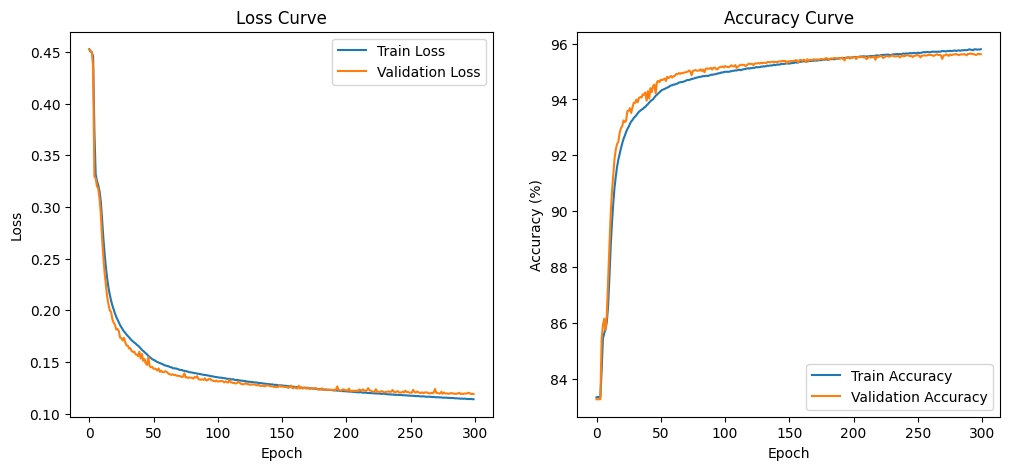

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend() 
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

Loaded dataset size: 171438
Accuracy: 0.9156021418821965
MCC: 0.8382612287436642
F1 Score: 0.909952016728798
AUC: 0.9840504824456136


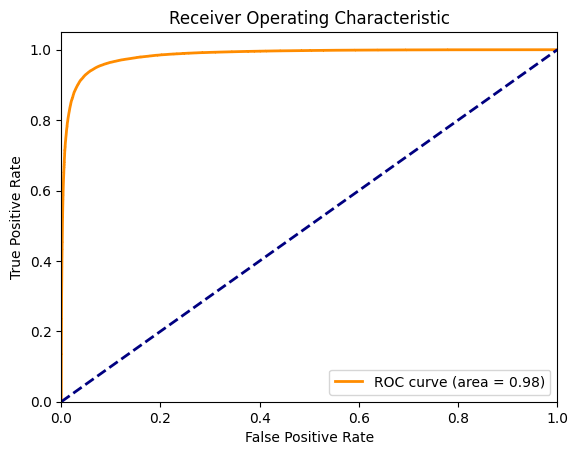

In [7]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score, matthews_corrcoef, f1_score
import numpy as np
Test = load_compressed('/kaggle/input/hla-antigen-datapre/transphla_test_embedding.pkl.gz')
print(f'Loaded dataset size: {len(Test)}')
test_loader = DataLoader(Test, batch_size=128, shuffle=True)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
y_true = []
y_pred = []
y_score = []
with torch.no_grad():
    for peptides, hla_seqs, labels in test_loader:
        peptides, hla_seqs, labels = peptides.to(device), hla_seqs.to(device), labels.to(device)
        outputs = model(peptides, hla_seqs)
        predictions = torch.sigmoid(outputs).cpu().numpy()
        y_score.extend(predictions)
        y_pred.extend(predictions.round())
        y_true.extend(labels.cpu().numpy())
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)
accuracy = accuracy_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

print(f'Accuracy: {accuracy}')
print(f'MCC: {mcc}')
print(f'F1 Score: {f1}')
print(f'AUC: {roc_auc}')

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()